<font size="5">__Symptoms prediction__<font>

In this notebook, we use data given by Pslove about their user's periods

# Data mining

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from joblib import dump, load
import seaborn as sns
%matplotlib inline

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [75]:
# Import files
user = pd.read_csv('User.csv', index_col=0)
period = pd.read_csv('Period.csv', index_col=0)
symptoms = pd.read_csv('Symptom.csv', index_col=0)

# Change data types to nice date types
user.cycle_length_initial = pd.to_timedelta(user.cycle_length_initial, unit='D').dt.days
user.period_length_initial = pd.to_timedelta(user.period_length_initial, unit='D').dt.days
user.dob = pd.to_datetime(user.dob, dayfirst=True, errors='coerce')
period.start_date = pd.to_datetime(period.start_date, dayfirst=True, errors='coerce')
period.end_date = pd.to_datetime(period.end_date, dayfirst=True, errors='coerce')
symptoms.date = pd.to_datetime(symptoms.date, dayfirst=True, errors='coerce')

## Cycle variations

In [76]:
# Calculate period length
period = period.join(user, on='User_id')
period['length'] = (period.end_date-period.start_date).dt.days + 1
period = period.drop(period[period.length<2].index)
period = period.drop(period[period.length>11].index)

# Calculate the rank of the user's period
period['order'] = 0
for user_id in user.index:
    index = period[period.User_id == user_id].sort_values('start_date').index
    period.loc[index, 'order'] = pd.Series(range(len(index)), index=index)

In [77]:
# Calculate days between periods
diff = period.loc[:, ['User_id', 'start_date']].sort_values(['User_id', 'start_date']).diff()
period['days_since_last'] = ((1 - diff.User_id) * diff.start_date).sort_index().dt.days
# If no previous period saved, fix length at 'cycle_length_initial'
index = period.loc[period.days_since_last==0].index
period.loc[index, 'days_since_last'] = period.cycle_length_initial

In [78]:
def last_period(x):
    # Return last first day of period
    user_period = period[period.User_id == x.user_id]
    last_date = user_period[user_period.start_date <= x.date].start_date.max()
    return last_date

def last_period_order(x):
    # Return last period order
    user_period = period[period.User_id == x.user_id]
    last_order = user_period[user_period.start_date <= x.date].order.max()
    return last_order

def last_len_period(x):
    # Return last period length
    liste = period[(period.User_id==x.user_id)&(period.start_date==x.last_period)].length
    if len(liste)==0:
        return 0
    else:
        return liste.iloc[0]

def last_len_cycle(x):
    # Return last cycle length
    liste = period[(period.User_id==x.user_id)&(period.start_date==x.last_period)].days_since_last
    if len(liste)==0:
        return 0
    else:
        return liste.iloc[0]

In [79]:
# Calculate mean cycle length
mean_cycle = period[period.days_since_last<50].groupby('User_id').mean()['days_since_last']
symptoms = symptoms.join(mean_cycle.rename('mean_cycle'), on='user_id')
# Calculate mean period length
mean_period = period.groupby('User_id').mean()['length']
symptoms = symptoms.join(mean_period.rename('mean_period'), on='user_id')

In [17]:
symptoms2 = symptoms.copy()
# Get features about last period
symptoms2['last_period'] = symptoms2.apply(last_period, axis=1)
symptoms2['last_order'] = symptoms2.apply(last_period_order, axis=1)
symptoms22['last_len_period'] = symptoms2.apply(last_len_period, axis=1)
symptoms['last_len_cycle'] = symptoms2.apply(last_len_cycle, axis=1)
symptoms2 = symptoms2.join(user, on='user_id')
# Days since period begin
symptoms2['period_day'] = (symptoms2.date - symptoms2.last_period).dt.days

In [121]:
dataFinalePropreX

,index,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore,differenceDays
0,0,33.5,0.0,21.5,0.0,0.0,0.0,0.0,0.0,0.0,48.5,-9.0
1,1,0.0,0.0,30.5,95.0,0.0,0.0,0.0,98.0,50.0,50.0,1.5
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,-8.5
3,3,61.0,0.0,32.5,81.0,0.0,0.0,0.0,0.0,32.5,28.5,-8.5
4,4,0.0,77.5,93.5,100.0,0.0,0.0,69.5,30.0,48.0,100.0,-2.0
5,5,29.0,100.0,97.5,100.0,0.0,32.0,42.5,0.0,0.0,75.0,-6.0
6,6,0.0,20.5,37.0,0.0,0.0,0.0,34.5,0.0,47.0,0.0,0.5
7,7,0.0,13.0,0.0,28.0,6.5,0.0,32.0,9.5,0.0,16.5,-0.5
8,8,8.0,30.0,0.0,16.5,0.0,0.0,0.0,0.0,0.0,0.0,1.5
9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,0.0,0.0,-10.5


In [120]:
symptoms.join(dataFinalePropreX, on='user_id')

,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore,date,mean_cycle,mean_period
id,,,,,,,,,,,,,,
127,252,0,0,0,0,0,0,0,0,0,0,2015-04-11,NaN,6.000000
128,257,0,0,0,46,0,0,0,0,0,0,2015-04-10,31.000000,5.500000
129,257,0,0,0,0,0,27,48,0,0,0,2015-04-11,31.000000,5.500000
130,263,0,0,0,0,0,0,0,0,0,0,2015-04-11,28.000000,4.000000
132,269,0,0,0,0,0,0,0,0,0,0,2015-04-11,30.833333,6.500000
133,270,0,0,0,0,0,0,0,0,0,0,2015-04-11,28.000000,6.000000
134,271,0,0,15,22,0,0,0,47,0,37,2015-04-11,31.500000,6.000000
135,254,0,0,0,0,0,0,0,0,0,0,2015-04-12,28.333333,6.000000
136,273,0,0,0,20,0,0,0,0,42,21,2015-04-12,30.000000,7.000000


In [28]:
# Create features and labels matrices
X = symptoms2.loc[:, ['period_day', 'last_len_period', 'last_len_cycle', 'mean_cycle', 'mean_period']]
Y = symptoms2.loc[:, ['acne', 'backache', 'bloating', 'cramp', 'diarrhea', 'dizzy', 'headache', 'mood', 'nausea', 'sore']]
#
X.last_len_period = X.last_len_period.fillna(X.mean_period)
X = X.dropna()
Y = Y.loc[X.index]
# Split traint test
X_train, X_test, y_train, y_test = train_test_split(X, Y)


## Previous period's symptoms

In [80]:
### The first thing is to create a dataset of users who ansswered more than 3 times
SymptomeAnswer=symptoms.groupby('user_id').size().reset_index(name='size')

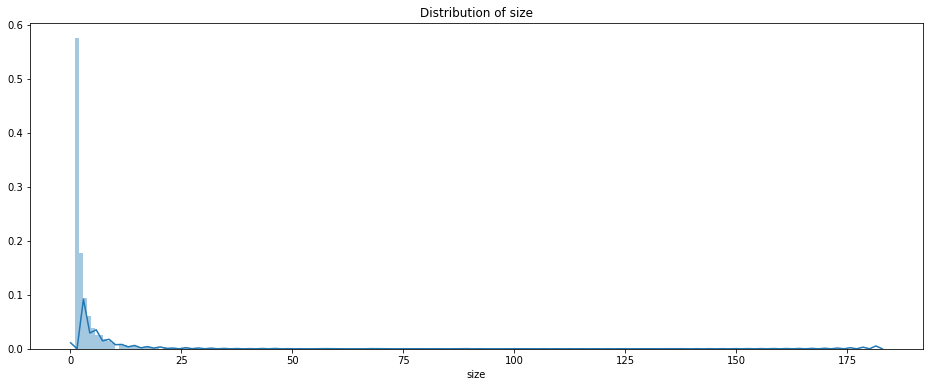

In [44]:
plt.figure(figsize=(16,6))
plt.title("Distribution of size")
sns.distplot(SymptomeAnswer['size'],bins=200)
plt.legend()
plt.show()

In [82]:
SymptomeAnswer=SymptomeAnswer[(SymptomeAnswer['size']>3)]
Symptom=symptoms.merge(SymptomeAnswer,on='user_id',how='inner')
Symptom=Symptom.merge(period,left_on='user_id',right_on='User_id')
Symptom['differenceDays']=(Symptom['date']-Symptom['start_date']).dt.days
### Select only the data with 13days of difference between the start of period and the date of symptoms
Symptom13days=Symptom[abs(Symptom['differenceDays'])<13]

In [85]:
### The first thing is to create a dataset of users who ansswered more than 3 times
SymptomNbOrder=Symptom13days.groupby('user_id').agg({'order':'nunique'}).reset_index().rename(columns={'order':'uniqueOrder'})


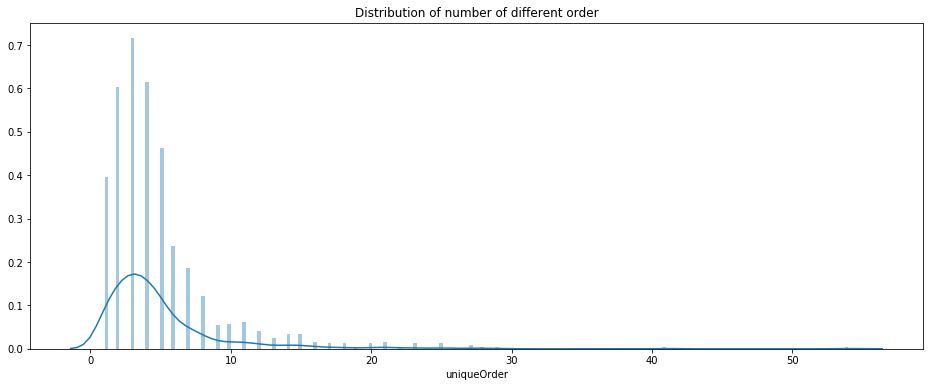

In [86]:
plt.figure(figsize=(16,6))
plt.title("Distribution of number of different order")
sns.distplot(SymptomNbOrder['uniqueOrder'],bins=200)
plt.legend()
plt.show()

In [87]:
SymptomNbOrderValid=SymptomNbOrder[(SymptomNbOrder['uniqueOrder']>3)&(SymptomNbOrder['uniqueOrder']<10)]
indexValid=SymptomNbOrderValid.user_id

Symptom13daysValid=Symptom13days[Symptom13days.user_id.isin(indexValid)].reset_index()
Symptom13daysValidDays=Symptom13daysValid.groupby(['user_id','order']).size().reset_index(name='sizeDaysInPeriod')
Symptom13daysValid=Symptom13daysValid.drop(columns=['index','User_id'])

Symptom13daysValid['orderInsideOrder'] = 0
for user_id in indexValid:
    index = Symptom13daysValid[Symptom13daysValid.user_id == user_id].sort_values('date').index
    Symptom13daysValid.loc[index, 'orderInsideOrder'] = pd.Series(range(len(index)), index=index)
    
SymptInt=Symptom13daysValid.groupby(['user_id','order'],as_index=False)['user_id','acne','backache','bloating','cramp','diarrhea','dizzy','headache','mood','nausea','sore'].mean()
SymptMean=SymptInt.groupby('user_id',as_index=False)['user_id','acne','backache','bloating','cramp','diarrhea','dizzy','headache','mood','nausea','sore'].mean()

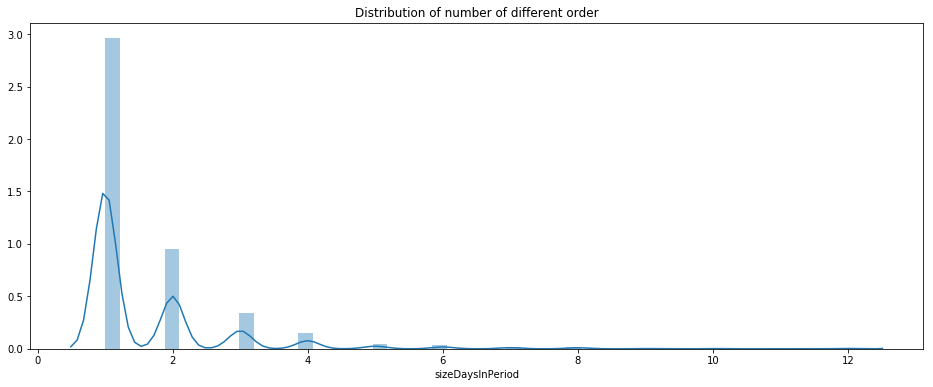

In [90]:
plt.figure(figsize=(16,6))
plt.title("Distribution of number of different order")
sns.distplot(Symptom13daysValidDays['sizeDaysInPeriod'],bins=50)
plt.legend()
plt.show()

In [95]:
SymptMean.head()

,user_id,acne,backache,bloating,cramp,diarrhea,dizzy,headache,mood,nausea,sore
0,278,5.142857,10.285714,4.928571,36.571429,12.285714,25.0,27.214286,5.357143,18.214286,5.571429
1,405,73.187500,62.500000,70.812500,53.125000,17.125000,49.0,51.437500,33.187500,37.750000,67.937500
2,490,7.428571,45.500000,55.571429,61.357143,0.000000,0.0,27.571429,18.000000,3.428571,26.357143
3,506,0.000000,46.250000,0.000000,0.000000,26.000000,8.0,9.000000,13.750000,0.000000,16.000000
4,569,7.066667,11.466667,2.866667,5.700000,0.000000,0.0,0.000000,7.700000,0.000000,18.766667


In [123]:
Symptom13daysValidInt=Symptom13daysValid.groupby(['user_id','order']).size().reset_index(name='sizeNbPeriods')
Symptom13daysValidFinal3=Symptom13daysValidInt[Symptom13daysValidInt['sizeNbPeriods']==3]
Symptom13daysValidFinal4=Symptom13daysValidInt[Symptom13daysValidInt['sizeNbPeriods']==4]
DataFinal0_3=Symptom13daysValid.merge(Symptom13daysValidFinal3,on=['user_id','order'],how='inner')
DataFinal0_4=Symptom13daysValid.merge(Symptom13daysValidFinal4,on=['user_id','order'],how='inner')
DataFinal1=DataFinal0_3.drop(columns=['date','size','start_date','end_date','order','orderInsideOrder','sizeNbPeriods'])
DataFinal2=DataFinal0_4.drop(columns=['date','size','start_date','end_date','order','orderInsideOrder','sizeNbPeriods'])
DataFinal1 = DataFinal1.drop(['mean_cycle', 'mean_period', 'dob', 'cycle_length_initial', 'period_length_initial', 'length', 'days_since_last'], axis=1)
DataFinal2 = DataFinal2.drop(['mean_cycle', 'mean_period', 'dob', 'cycle_length_initial', 'period_length_initial', 'length', 'days_since_last'], axis=1)

columns=DataFinal1.columns
columns1=[x+'_1' for x in columns]
columns2=[x+'_2' for x in columns]
columnsTrain=np.concatenate((columns1, columns2))

n1=len(DataFinal1)//3
n2=len(DataFinal2)//4
dataFinaleX_1=pd.DataFrame(columns=columns)
dataFinaleY_1=pd.DataFrame(columns=columns)
dataFinaleX_2=pd.DataFrame(columns=columns)
dataFinaleY_2=pd.DataFrame(columns=columns)
# DataFinal1.iloc[0].append(DataFinal1.iloc[1])

for i in range(0,n1):
    a=(DataFinal1.iloc[3*i]+DataFinal1.iloc[3*i+1])/2
    a.index=columns
    dataFinaleX_1.loc[i]=a
    dataFinaleY_1.loc[i]=DataFinal1.iloc[3*i+2]
for i in range(0,n2):
    a=(DataFinal2.iloc[4*i]+DataFinal2.iloc[4*i+1])/2
    a.index=columns
    dataFinaleX_2.loc[i]=a
    dataFinaleY_2.loc[i]=DataFinal1.iloc[4*i+2]

dataFinalePropreX_1=dataFinaleX_1.drop(columns='user_id')
dataFinalePropreY_1=dataFinaleY_1.drop(columns=['user_id','differenceDays'])

dataFinalePropreX_2=dataFinaleX_2.drop(columns='user_id')
dataFinalePropreY_2=dataFinaleY_2.drop(columns=['user_id','differenceDays'])

dataFinalePropreX=pd.concat([dataFinalePropreX_1, dataFinalePropreX_2]).reset_index()
dataFinalePropreY=pd.concat([dataFinalePropreY_1, dataFinalePropreY_2]).reset_index()


In [127]:
# Split traint test
X_train, X_test, y_train, y_test = train_test_split(dataFinalePropreX, dataFinalePropreY)

In [128]:
# Here the merge between the two datasets remains to be done

# Machine learning

In [31]:
# Grid search to get the best model using RandomForest
# Specify parameters to sample from
param_grid = {"n_estimators" : [20, 50, 100],
              "max_depth": [5, 10, None],
              "max_features": [2, 3, 4],
              "min_samples_split": [5, 10, 20],
              "bootstrap": [True, False]}
#
rfr = RandomForestRegressor()
# run grid search
grid_search = GridSearchCV(rfr, param_grid, cv=3, n_jobs=-1)
grid_search.fit(X, Y)
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 10,
 'max_features': 3,
 'min_samples_split': 10,
 'n_estimators': 100}

In [37]:
# Save model
dump(rfr, 'model1.joblib')

['model1.joblib']

In [131]:
# Get the model (from grid search or load it)
#rfr = grid_search.best_estimator_
rfr = load('model1.joblib')

# Fit and get score
rfr.fit(X_train, y_train)
rfr.score(X_test, y_test)

0.2892642355253314